In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse.linalg import eigs
import logging

from anonymigraph.anonymization.method_private_colors_climbing import (
    LocalSearchColorOptimizer,
    Optimal1dColorOptimizer,
)
    
from anonymigraph.anonymization._method_private_colors.helpers import SamplingFreeEvaluator
from anonymigraph.anonymization.method_private_colors_soft_assignment import SoftColorOptimizer


logging.basicConfig(level=logging.INFO,)

In [2]:
def evaluate(G, alpha, w, seed, beta=1):
    eager_local_search = LocalSearchColorOptimizer(G, w=w, alpha=alpha, beta=beta, is_eager=True)
    eager_local_search.fit(seed = seed)

    greedy_local_search = LocalSearchColorOptimizer(G, w=w, alpha=alpha, beta=beta, is_eager=False)
    greedy_local_search.fit()

    opti1d_coloropti = Optimal1dColorOptimizer(G, w=w, alpha=alpha, beta=beta)
    opti1d_coloropti.fit()

    sf_eval_opti1d = SamplingFreeEvaluator(G, opti1d_coloropti.colors, w=w, alpha=alpha, beta=beta, use_katz_utility=True)
    eval_opti1d = sf_eval_opti1d.get_results()
    logging.info(f"Optimal 1D         : "
                 f"num_clusters={eval_opti1d['num_clusters']}, "
                 f"sub_opt_gap={eval_opti1d['sub_opt_gap']:.5g}, "
                 f"total_loss={eval_opti1d['total_loss']:.5g}, "
                 f"loss_U={eval_opti1d['loss_U']:.5g}, "
                 f"loss_P={eval_opti1d['loss_P']:.5g} ")

    sf_eval_eager_local_search = SamplingFreeEvaluator(G, eager_local_search.colors, w=w, alpha=alpha, beta=beta, use_katz_utility=True)
    eval_eager_local_search = sf_eval_eager_local_search.get_results()
    logging.info(f"Eager Local Search : "
                f"num_clusters={eval_eager_local_search['num_clusters']}, "
                f"sub_opt_gap={eval_eager_local_search['sub_opt_gap']:.5g}, "
                f"total_loss={eval_eager_local_search['total_loss']:.5g}, "
                f"loss_U={eval_eager_local_search['loss_U']:.5g}, "
                f"loss_P={eval_eager_local_search['loss_P']:.5g} ")

    sf_eval_greedy_local_search = SamplingFreeEvaluator(G, greedy_local_search.colors, w=w, alpha=alpha, beta=beta, use_katz_utility=True)
    eval_greedy_local_search = sf_eval_greedy_local_search.get_results()
    logging.info(f"Greedy Local Search: "
                f"num_clusters={eval_greedy_local_search['num_clusters']}, "
                f"sub_opt_gap={eval_greedy_local_search['sub_opt_gap']:.5g}, "
                f"total_loss={eval_greedy_local_search['total_loss']:.5g}, "
                f"loss_U={eval_greedy_local_search['loss_U']:.5g}, "
                f"loss_P={eval_greedy_local_search['loss_P']:.5g} ")

    soft_optim_katz = SoftColorOptimizer(
        G, k_max=50, w=w,
        use_katz_utility = True,
        use_entropy_reg = True,
        alpha=alpha, beta=beta,
        eps_utility = 1e-9, eps_privacy = 1e-9,
        lr=0.1, patience=20, threshold=1e-3, initial_lam=1e-7, factor=1.1,
        device='cpu', seed=seed
    )

    soft_optim_katz.fit(max_epochs=int(1e8), epoch_report_frequency=1000)
    sf_eval_soft_assign_katz = SamplingFreeEvaluator(G, soft_optim_katz.colors, w=w, alpha=alpha, beta=beta, use_katz_utility=True)
    eval_soft_assign_katz = sf_eval_soft_assign_katz.get_results()
    logging.info(f"Soft Assign w/ Entropy Reg.: "
                f"num_clusters={eval_soft_assign_katz['num_clusters']}, "
                f"sub_opt_gap={eval_soft_assign_katz['sub_opt_gap']:.5g}, "
                f"total_loss={eval_soft_assign_katz['total_loss']:.5g}, "
                f"loss_U={eval_soft_assign_katz['loss_U']:.5g}, "
                f"loss_P={eval_soft_assign_katz['loss_P']:.5g} ")

    return {"Optimal 1D": eval_opti1d, "First-Improv.": eval_eager_local_search, "Best-Improv.": eval_greedy_local_search, "Soft Assign": eval_soft_assign_katz}


def no_self_loops_LFR(*args, **kwargs):
    G = nx.generators.community.LFR_benchmark_graph(*args, **kwargs)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G


graph_types = {
    "Erdos-Renyi":  nx.erdos_renyi_graph,
    "Barabasi-Albert": nx.barabasi_albert_graph,
    "LFR": no_self_loops_LFR
}

graph_params = {
    "Erdos-Renyi": {"n": 200, "p": 0.05, "seed": 1, "g_type": "Erdos-Renyi"}, # Erdos-Renyi - No High Degree Nodes
    "Barabasi-Albert": {"n": 200, "m": 5, "seed": 1, "g_type": "Barabasi-Albert"},
    "LFR": {"n": 200, "tau1": 3, "tau2": 1.5, "mu": 0.1, "average_degree": 7, "seed": 42, "min_community": 60, "g_type": "LFR"} # Default LFR - PowerLaw + Communities
    #"Barabasi-Albert (Dense)": {"n": 200, "m": 10, "seed": 42, "g_type": "Barabasi-Albert"},
}


# Encodes grid of Graph x Relative Alpha x w (dicts are nested in this order)
g_rel_alpha_w_grid = {
    "Erdos-Renyi": {
        0.9:  10**(-np.linspace(-2, 2, 4 + 1)),
        0.01: 10**(-np.linspace(4, 8, 4 + 1)),
    },
    "Barabasi-Albert": {
        0.9: 10**(-np.linspace(-2, 2, 4 + 1)),
        0.01: 10**(-np.linspace(4, 8, 4 + 1)),
    },
    "LFR": {
        0.9:  10**(-np.linspace(-1, 2, 3 + 1)),
        0.01: 10**(-np.linspace(4, 9, 4 + 1)),
    }
}


graphs = {}

for graph_name in g_rel_alpha_w_grid.keys():
    params = graph_params[graph_name].copy()
    g_type = params.pop("g_type")
    graphs[graph_name] = graph_types[g_type](**params)

results = []

for graph_name in g_rel_alpha_w_grid.keys():
    G = graphs[graph_name]

    eigenvalues, _ = eigs(nx.adjacency_matrix(G).astype(np.float64), k=1, which='LM')
    max_alpha = 1 / np.abs(eigenvalues).max()

    for rel_alpha in g_rel_alpha_w_grid[graph_name]:
        for w in g_rel_alpha_w_grid[graph_name][rel_alpha]:
            logging.info(f"Evaluating with parameters: w={w:.3g}, rel_alpha={rel_alpha:.3g}, G_name={graph_name}, G={str(G)}, seed={params["seed"]}")

            algo_results = evaluate(G, rel_alpha * max_alpha, w, graph_params[graph_name]["seed"])
            for algo_name in algo_results:
                row = {
                    "graph": graph_name,
                    "algo": algo_name,
                    "rel_alpha": rel_alpha,
                    "w": w,
                    **algo_results[algo_name]
                }
                results.append(row)

df_results = pd.DataFrame(results)

INFO:root:Evaluating with parameters: w=100, rel_alpha=0.9, G_name=Erdos-Renyi, G=Graph with 200 nodes and 1025 edges, seed=42
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:anonymigraph.anonymization._method_private_colors.optimizers:Optimal 1d: k=1,  total_loss=8128.1646, loss_U=1666.4085, loss_P=64.6176
INFO:anonymigraph.anonymization._method_private_colors.optimizers:Optimal 1d: k=2,  total_loss=8226.6103, loss_U=621.0867, loss_P=76.0552
INFO:anonymigraph.anonymization._method_private_colors.optimizers:Optimal 1d: k_best=1,  total_loss=8128.1646, loss_U=1666.4085, loss_P=64.6176
INFO:anonymigraph.utils:Katz converged after 287 iterations.
INFO:root:Optimal 1D         : num_clusters=1, sub_opt_gap=1666.4, total_loss=8128.2, 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

rank_counts = Counter()
rows = []

for graph_name in g_rel_alpha_w_grid.keys():
    for rel_alpha in g_rel_alpha_w_grid[graph_name]:
        for w in g_rel_alpha_w_grid[graph_name][rel_alpha]:
            df_graph = df_results[(df_results['graph'] == graph_name) & (df_results['rel_alpha'] == rel_alpha) & (df_results['w'] == w)]
            num_clusters_opt1d = df_graph[df_graph["algo"] == "Optimal 1D"]["num_clusters"].item()
            gap_opt1d = df_graph[df_graph["algo"] == "Optimal 1D"]["sub_opt_gap"].item()
            gap_eager = df_graph[df_graph["algo"] == "First-Improv."]["sub_opt_gap"].item()
            gap_greedy = df_graph[df_graph["algo"] == "Best-Improv."]["sub_opt_gap"].item()
            gap_soft = df_graph[df_graph["algo"] == "Soft Assign"]["sub_opt_gap"].item()

            gaps = {"Soft Assign": gap_soft, "Optimal 1D": gap_opt1d,"Eager": gap_eager,"Greedy": gap_greedy, "num_clusters_opt1d":num_clusters_opt1d}
            rows.append(gaps)

            # for ranking
            df = pd.DataFrame(list(gaps.items()), columns=['algo', 'gap'])
            df['rank'] = df['gap'].rank(method='average', ascending=True)

            for _, row in df.iterrows():
                rank_counts[(row['algo'], row['rank'])] += 1

average_ranks = (
    pd.DataFrame([(algo, rank * freq, freq) for (algo, rank), freq in rank_counts.items()],
                 columns=["algo", "rank_sum", "count"])
    .groupby("algo")
    .apply(lambda x: x["rank_sum"].sum() / x["count"].sum(), include_groups=False)
    .sort_values()
)
display(average_ranks)


# Normalize
df = pd.DataFrame(rows)
df["Soft Assign"] = df["Soft Assign"] / df["Greedy"]
df["Optimal 1D"] = df["Optimal 1D"] / df["Greedy"]
df["Eager"] = df["Eager"] / df["Greedy"]
df["Greedy"] = df["Greedy"] / df["Greedy"]

# Hue Choice
df.rename(columns={"num_clusters_opt1d": "hue"}, inplace=True)
#df['hue'] = df["Optimal 1D"]
df['hue'] = df['hue'] + np.random.normal(0, 1e-7, size=len(df)) # need unique values here, otherwise we plot areas in parallel coords

algo
Greedy                1.913793
Eager                 1.965517
num_clusters_opt1d    3.482759
Optimal 1D            3.500000
Soft Assign           4.137931
dtype: float64

In [4]:
df_stats = df.where(df <= 2, np.nan)
df_stats = df_stats.drop("hue", axis=1)
stats = df_stats.describe()
stats = stats.drop(["count", "25%", "75%", "std"])
latex_code = stats.to_latex(index=True,
                         caption="Descriptive statistics for the normalized suboptimality gaps for the proposed algorithms across various graphs and hyperparameter configurations.",
                         label="tab:exp1_descriptive",
                         bold_rows=True,
                         column_format="lcccc",
                         float_format="%.2f"
)

print(latex_code)

\begin{table}
\caption{Descriptive statistics for the normalized suboptimality gaps for the proposed algorithms across various graphs and hyperparameter configurations.}
\label{tab:exp1_descriptive}
\begin{tabular}{lcccc}
\toprule
 & Soft Assign & Optimal 1D & Eager & Greedy \\
\midrule
\textbf{mean} & 1.16 & 1.05 & 1.00 & 1.00 \\
\textbf{min} & 1.00 & 1.00 & 0.99 & 1.00 \\
\textbf{50%} & 1.08 & 1.02 & 1.00 & 1.00 \\
\textbf{max} & 1.76 & 1.33 & 1.02 & 1.00 \\
\bottomrule
\end{tabular}
\end{table}



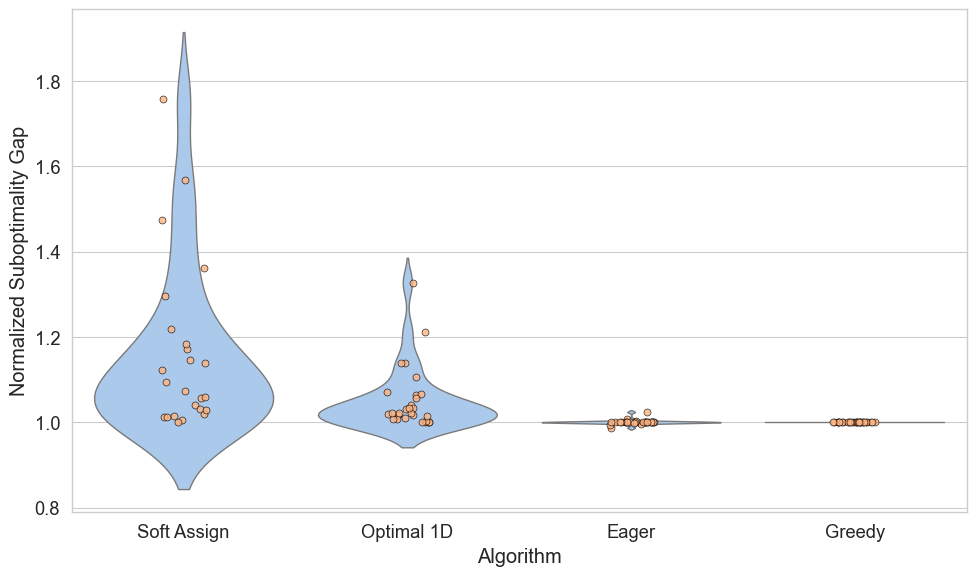

In [7]:
# Violin plot
df_long_no_outlier = df.melt(id_vars='hue', var_name='algorithm', value_name='gap')
df_long_no_outlier["gap"] = df_long_no_outlier["gap"].where(df_long_no_outlier["gap"] <= 2, np.nan)

sns.set_theme(style="whitegrid", context="paper", palette="pastel", font_scale=1.5)

plt.figure(figsize=(10, 6))
sns.violinplot(x='algorithm', y='gap', data=df_long_no_outlier, inner=None, linewidth=1, density_norm="width", bw_method=0.4)
sns.stripplot(x='algorithm', y='gap', data=df_long_no_outlier, jitter=True, edgecolor="black", linewidth=0.5, alpha=0.8)

plt.ylabel('Normalized Suboptimality Gap')
plt.xlabel('Algorithm')

plt.tight_layout()

plt.savefig("figures/suboptimality_gap_improvements.pdf", bbox_inches='tight')
plt.show()


In [6]:
pivot_dfs = {}
for graph_name in g_rel_alpha_w_grid.keys():
    for rel_alpha in g_rel_alpha_w_grid[graph_name]:
        df_graph = df_results[(df_results['graph'] == graph_name) & (df_results['rel_alpha'] == rel_alpha)]
        pivot_df = df_graph.pivot(index='w', columns=['algo'], values=['sub_opt_gap', 'num_clusters', 'total_loss', 'loss_U', 'loss_P'])
        pivot_df.sort_index(axis=0, inplace=True, ascending=False)
        pivot_df = pivot_df.reindex(columns=['First-Improv.', 'Best-Improv.', 'Optimal 1D', 'Soft Assign'], level=1)

        pivot_dfs[graph_name] = pivot_dfs.get(graph_name, {})
        pivot_dfs[graph_name][rel_alpha] = pivot_df

        print(f"Graph Name: {graph_name}, rel_alpha: {rel_alpha}, {str(graphs[graph_name])}")
        display(pivot_df.style.format(formatter="{:.4g}").format_index("{:.3g}", axis=0))


Graph Name: Erdos-Renyi, rel_alpha: 0.9, Graph with 200 nodes and 1025 edges


Graph Name: Erdos-Renyi, rel_alpha: 0.01, Graph with 200 nodes and 1025 edges


Graph Name: Barabasi-Albert, rel_alpha: 0.9, Graph with 200 nodes and 975 edges


Graph Name: Barabasi-Albert, rel_alpha: 0.01, Graph with 200 nodes and 975 edges


Graph Name: LFR, rel_alpha: 0.9, Graph with 200 nodes and 634 edges


Graph Name: LFR, rel_alpha: 0.01, Graph with 200 nodes and 634 edges
